# Gaze directed slightly forward toward ground

In [1]:
import cv2
import os

# Path to input and output directories
input_dir = "stage4"
output_dir = "stage5-40-frames"
os.makedirs(output_dir, exist_ok=True)

target_frames = 40  # Target number of frames per video

def truncate_or_pad_video(video_path, output_path, target_frames):
    """
    Truncate or pad a video to ensure it has exactly `target_frames` frames.

    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the processed video.
        target_frames (int): Desired number of frames.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter for the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    if len(frames) < target_frames:
        # Pad by duplicating frames
        while len(frames) < target_frames:
            frames.append(frames[-1])  # Duplicate the last frame
    elif len(frames) > target_frames:
        # Truncate to the first 130 frames
        frames = frames[:target_frames]

    # Write the processed frames to the output video
    for frame in frames:
        out.write(frame)
    out.release()

# Process all videos in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".mp4"):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file)
        truncate_or_pad_video(input_path, output_path, target_frames)

print("All videos resized to exactly 130 frames using truncate or pad method.")


All videos resized to exactly 130 frames using truncate or pad method.


In [2]:
import os
import cv2
import mediapipe as mp
import json
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False)

def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def calculate_angle(a, b, c):
    """
    Calculate the angle formed by three points (a, b, c) where 'b' is the vertex.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle)

def calculate_gaze_features(landmarks, w, h):
    """
    Calculate gaze-related features using nose and eye landmarks.
    """
    nose = [landmarks[mp_pose.PoseLandmark.NOSE].x * w, landmarks[mp_pose.PoseLandmark.NOSE].y * h]
    left_eye = [landmarks[mp_pose.PoseLandmark.LEFT_EYE].x * w, landmarks[mp_pose.PoseLandmark.LEFT_EYE].y * h]
    right_eye = [landmarks[mp_pose.PoseLandmark.RIGHT_EYE].x * w, landmarks[mp_pose.PoseLandmark.RIGHT_EYE].y * h]

    # Calculate midpoint of eyes
    mid_eye = [(left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2]

    # Vector from nose to midpoint of eyes (gaze direction vector)
    gaze_vector = [mid_eye[0] - nose[0], mid_eye[1] - nose[1]]

    # Normalize gaze vector
    gaze_magnitude = np.linalg.norm(gaze_vector)
    normalized_gaze_vector = [v / gaze_magnitude for v in gaze_vector] if gaze_magnitude > 0 else [0, 0]

    # Calculate gaze angle with respect to vertical axis
    gaze_angle = np.arctan2(gaze_vector[1], gaze_vector[0])  # Radians
    gaze_angle_degrees = np.degrees(gaze_angle)

    return {
        "gaze_vector": normalized_gaze_vector,
        "gaze_angle_degrees": gaze_angle_degrees
    }

def extract_keypoints_and_features_from_frame(frame_path):
    """
    Extract keypoints and calculated features from a single frame.
    """
    image = cv2.imread(frame_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb_image)

    if result.pose_landmarks:
        h, w, _ = image.shape
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints
        keypoints = [
            {"x": lm.x, "y": lm.y, "z": lm.z, "visibility": lm.visibility}
            for lm in landmarks
        ]

        # Relevant landmarks for gaze analysis
        nose = [landmarks[mp_pose.PoseLandmark.NOSE].x, landmarks[mp_pose.PoseLandmark.NOSE].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]

        # Body reference calculations
        shoulder_width = calculate_distance(left_shoulder, right_shoulder)

        # Gaze features
        gaze_features = calculate_gaze_features(landmarks, w, h)

        # Normalize keypoints relative to shoulder width
        normalized_keypoints = [
            {"x": lm.x / shoulder_width, "y": lm.y / shoulder_width, "z": lm.z / shoulder_width, "visibility": lm.visibility}
            for lm in landmarks
        ]

        return {
            "keypoints": normalized_keypoints,
            "gaze_features": gaze_features,
            "shoulder_width": shoulder_width
        }
    return None

def process_frames(video_frames_dir, output_path, frame_skip=3):
    """
    Process every nth frame for a video and save keypoints and features as JSON.
    """
    keypoints_data = []
    frame_count = 0  # Initialize frame counter

    for frame_file in sorted(os.listdir(video_frames_dir)):
        frame_path = os.path.join(video_frames_dir, frame_file)

        # Skip frames based on frame_skip
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        keypoints = extract_keypoints_and_features_from_frame(frame_path)
        if keypoints:
            keypoints_data.append(keypoints)

        frame_count += 1  # Increment frame counter

    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

# Paths
frames_dir = "stage5-frames"
keypoints_dir = "stage5-dataset-json"
os.makedirs(keypoints_dir, exist_ok=True)

# Process frames for each video with frame skipping
for video_name in os.listdir(frames_dir):
    video_frames_dir = os.path.join(frames_dir, video_name)
    if os.path.isdir(video_frames_dir):
        output_path = os.path.join(keypoints_dir, f"{video_name}_keypoints.json")
        process_frames(video_frames_dir, output_path, frame_skip=2)  # Skip 2 frames, process every 3rd frame
        print(f"Keypoints extracted for {video_name}")

print("Keypoint extraction completed!")


Keypoints extracted for user102_brightness_frames
Keypoints extracted for user102_mirrored_frames
Keypoints extracted for user102_noise_frames
Keypoints extracted for user102_original_frames
Keypoints extracted for user102_rotate_frames
Keypoints extracted for user103_brightness_frames
Keypoints extracted for user103_mirrored_frames
Keypoints extracted for user103_noise_frames
Keypoints extracted for user103_original_frames
Keypoints extracted for user103_rotate_frames
Keypoints extracted for user10_brightness_frames
Keypoints extracted for user10_mirrored_frames
Keypoints extracted for user10_noise_frames
Keypoints extracted for user10_original_frames
Keypoints extracted for user10_rotate_frames
Keypoints extracted for user11_brightness_frames
Keypoints extracted for user11_mirrored_frames
Keypoints extracted for user11_noise_frames
Keypoints extracted for user11_original_frames
Keypoints extracted for user11_rotate_frames
Keypoints extracted for user12_brightness_frames
Keypoints ext

In [6]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Paths
json_folder = "stage5-dataset-json"  # Folder containing JSON files with extracted features
labels_file = "stage5-dataset.csv"   # File with user labels (e.g., user1: 0, user2: 1)

# Load labels (assumes a CSV file with 'user' and 'label' columns)
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

# Dataset preparation
X = []  # Features
y = []  # Labels
max_sequence_length = 40  # Fixed sequence length for LSTM or Transformer

for json_file in sorted(os.listdir(json_folder)):
    user_id = os.path.splitext(json_file)[0]  # Extract user ID from file name
    if user_id not in label_mapping:
        print(f"Label not found for {user_id}. Skipping...")
        continue

    label = label_mapping[user_id]  # Get label for the user
    json_path = os.path.join(json_folder, json_file)

    # Load JSON data
    with open(json_path, "r") as file:
        data = json.load(file)

    user_features = []
    for frame in data:
        try:
            # Extract specific features
            gaze_vector = frame["gaze_features"]["gaze_vector"]  # Gaze direction vector
            gaze_angle_degrees = frame["gaze_features"]["gaze_angle_degrees"]  # Gaze angle

            body_height = frame.get("body_height", 0)
            torso_length = frame.get("torso_length", 0)

            # Combine features into a single vector
            features = [gaze_angle_degrees, body_height, torso_length] + gaze_vector
            user_features.append(features)
        except KeyError as e:
            print(f"Missing key {e} in {json_file}. Skipping frame...")
            continue

    # Append features and label
    if user_features:
        X.append(user_features)
        y.append(label)

# Pad sequences to ensure consistent lengths
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences
num_features = X_train.shape[2]     # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

# Display dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (77, 40, 5), y_train shape: (77,)
X_val shape: (33, 40, 5), y_val shape: (33,)


In [1]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Paths
json_folder = "stage5-dataset-json"  # Folder containing JSON files
labels_file = "stage5-dataset.csv"   # File with user labels

# Load labels (assumes a CSV file with 'user' and 'label' columns)
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

# Dataset preparation
X = []  # Features
y = []  # Labels
max_sequence_length = 40  # Fixed sequence length for LSTM or Transformer

for json_file in sorted(os.listdir(json_folder)):
    user_id = os.path.splitext(json_file)[0]  # Extract user ID from file name
    if user_id not in label_mapping:
        print(f"Label not found for {user_id}. Skipping...")
        continue

    label = label_mapping[user_id]  # Get label for the user
    json_path = os.path.join(json_folder, json_file)

    # Load JSON data
    with open(json_path, "r") as file:
        data = json.load(file)

    user_features = []
    for frame in data:
        try:
            # Extract gaze features
            gaze_vector = frame["gaze_features"]["gaze_vector"]  # Gaze direction vector
            gaze_angle_degrees = frame["gaze_features"]["gaze_angle_degrees"]  # Gaze angle

            # Extract additional features
            body_height = frame.get("body_height", 0)
            torso_length = frame.get("torso_length", 0)
            shoulder_width = frame.get("shoulder_width", 0)

            # Combine features into a single vector
            features = [gaze_angle_degrees, body_height, torso_length, shoulder_width] + gaze_vector
            user_features.append(features)
        except KeyError as e:
            print(f"Missing key {e} in {json_file}. Skipping frame...")
            continue

    # Append features and label
    if user_features:
        X.append(user_features)
        y.append(label)

# Pad sequences to ensure consistent lengths
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences
num_features = X_train.shape[2]     # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

# Display dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (77, 40, 6), y_train shape: (77,)
X_val shape: (33, 40, 6), y_val shape: (33,)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Use class weights to address imbalance
    # callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the model
model.save("stage5.keras")
print("Model training complete and saved as 'stage5-gaze-lstm.keras'")


Class weights: {0: 0.6875, 1: 1.8333333333333333}
Epoch 1/100
5/5 [==============================] - 6s 478ms/step - loss: 0.2536 - mae: 0.5115 - val_loss: 0.2645 - val_mae: 0.5134
Epoch 2/100
5/5 [==============================] - 2s 414ms/step - loss: 0.2505 - mae: 0.5084 - val_loss: 0.2553 - val_mae: 0.5051
Epoch 3/100
5/5 [==============================] - 2s 483ms/step - loss: 0.2500 - mae: 0.5047 - val_loss: 0.2542 - val_mae: 0.5041
Epoch 4/100
5/5 [==============================] - 2s 430ms/step - loss: 0.2491 - mae: 0.5032 - val_loss: 0.2515 - val_mae: 0.5015
Epoch 5/100
5/5 [==============================] - 2s 432ms/step - loss: 0.2493 - mae: 0.5013 - val_loss: 0.2496 - val_mae: 0.4996
Epoch 6/100
5/5 [==============================] - 2s 409ms/step - loss: 0.2476 - mae: 0.4991 - val_loss: 0.2521 - val_mae: 0.5020
Epoch 7/100
5/5 [==============================] - 2s 381ms/step - loss: 0.2500 - mae: 0.5054 - val_loss: 0.2554 - val_mae: 0.5051
Epoch 8/100
5/5 [================

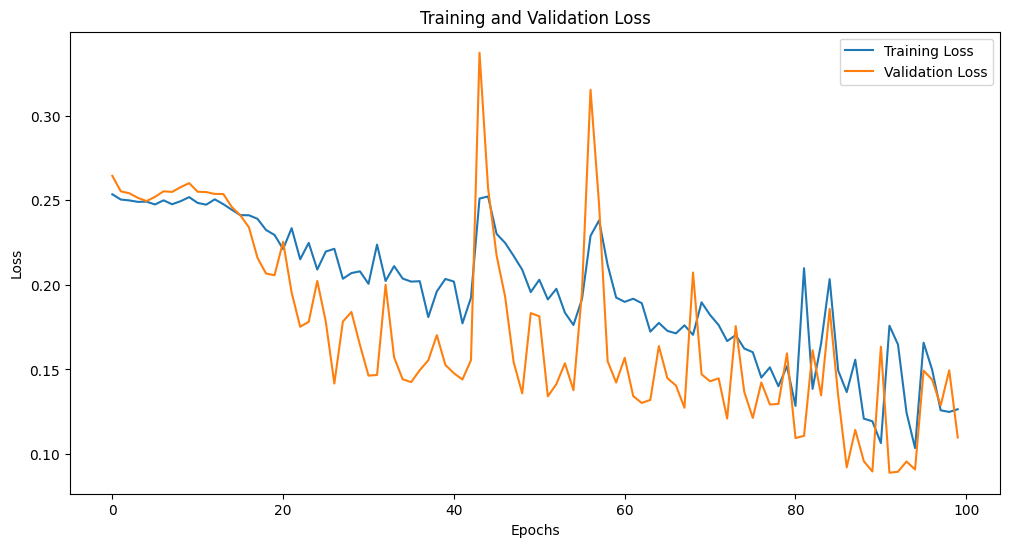

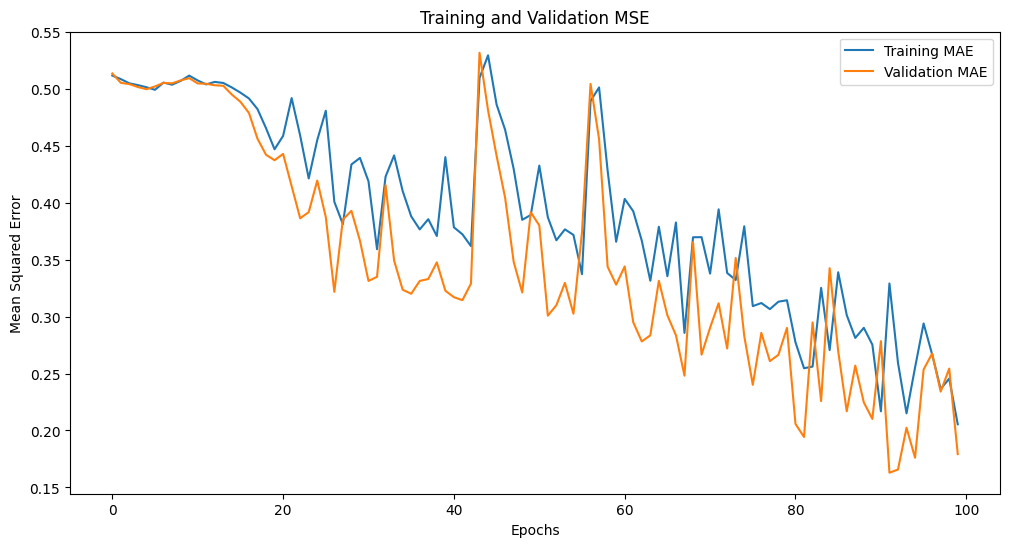

In [3]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [4]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

# Define threshold
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)

# Load the trained model
model = load_model("stage5.keras")

# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("5validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)


2/2 [==============================] - 0s 50ms/step
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           0         0.611093                1
1           0         0.018657                0
2           0         0.081548                0
3           0         0.035915                0
4           0         0.024032                0
Accuracy: 0.85
Confusion Matrix:
[[22  2]
 [ 3  6]]


2/2 [==============================] - 0s 48ms/step
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


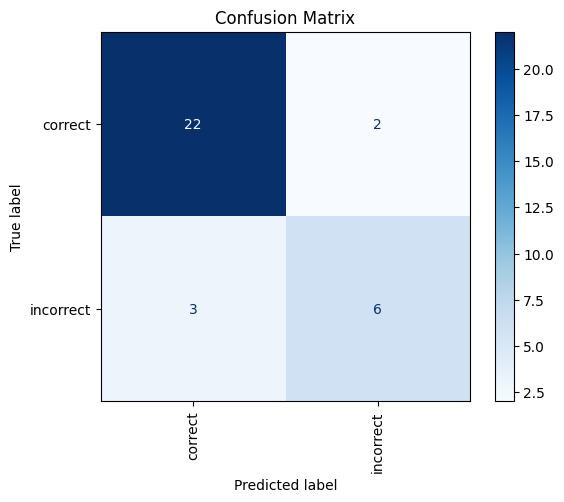

Accuracy: 0.85


In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
# threshold = 0.005  # Adjust this value to experiment with different thresholds
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)


# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")
